# **Разностные методы решения задачи Дирихле для двумерного уравнения Пуассона в прямоугольнике.**
## **Метод установления. Схема переменных направлений.**

<span style="font-style:normal; font-size:14pt;">

Схема переменных направлений - экономичный($O(N_x N_y)$) и неявный метод(устойчивость).

$$
\begin{cases}
-Lu = f(x,y), \ \ \ \ 0 < x < 2, \ \ \ \  0 < y < 1  \\
\left. u\right|_S = \left.\mu\right|_S        \\ 
\end{cases}
$$

$$
\begin{equation}
u_0 = (3x + y^{2}) \cos(x + 2y) + x^{2}
\end{equation}
$$
    
> Из аналитического решение получим неоднородности:
    
$$
\begin{align}
    &f(x, y) = -(-2 \sin(x + 2y) [3 + 4y] + \cos(x + 2y) [-5y^{2} - 15x + 2] + 2),   \\
    &u(0, y) = y^{2} \cos{2y}                  \\
    &u(2, y) = (6 + y^{2}) \cos(2 + 2y) + 4    \\
    &u(x, 0) = 3x \cos{x} + x^{2}              \\
    &u(x, 1) = (3x + 1) \cos(x + 2) + x^2      \\
\end{align}
$$

> Решаем вспомогательную нестационарную задачу:
$$
\begin{cases}
u_t = u_{xx} + u_{yy} + f(x,y), \ \ \ \ 0 < x < 2, \ \ \ \  0 < y < 1  \\
\left. u\right|_S = \left.\mu\right|_S        \\ 
u(x, y, 0) = \gamma(x, y)                        \\ 
\end{cases}
$$ 
$\gamma$ - произвольно. Примем $\gamma = 0$

In [93]:
import numpy as np
import matplotlib.pyplot as plt

In [94]:
# Метод прогонки для решения СЛАУ
def Thomas_algorithm(a_plot, b_plot, c_plot, f_plot):
    n = len(f_plot)
    y_plot = []
        
    A_plot = []
    B_plot = []
    
    A0 = (-1) * c_plot[0] / b_plot[0]
    B0 = f_plot[0] / b_plot[0]
    
    A_plot.append(A0)
    B_plot.append(B0)
    
    for i in range(1, n - 1):
        Ai = (-1) * c_plot[i] / (b_plot[i] + a_plot[i] * A_plot[i - 1])
        A_plot.append(Ai)
    
    for i in range(1, n):
        Bi = (f_plot[i] - a_plot[i] * B_plot[i - 1]) / (b_plot[i] + a_plot[i] * A_plot[i - 1])
        B_plot.append(Bi)
    
    An = 0   
    A_plot.append(An)    
    
    y_plot.append(B_plot[n - 1])
    
    for i in range(n - 2, -1, -1):
        yi = B_plot[i] + A_plot[i] * y_plot[0]
        y_plot.insert(0, yi)
    
    return y_plot

### **Постановка задачи**

In [95]:
# Аналитическое решение
def u(x, y):
    return (3 * x + y**2) * np.cos(x + 2 * y) + x**2

# Неоднородность
def f(x, y):
    return (-1) * ((-2) * np.sin(x + 2 * y) * (3 + 4 * y) + np.cos(x + 2 * y) * (-5 * y**2 - 15 * x + 2) + 2)

# Граничные условия

# ГУ для оси x (левый и правый конец)
def mu_x(y):
    mu_x1 = y**2 * np.cos(2 * y)
    mu_x2 = (6 + y**2) * np.cos(2 + 2 * y) + 4
    return [mu_x1, mu_x2]

# ГУ для оси y (нижняя и верхняя границы)
def mu_y(x):
    mu_y1 = 3 * x * np.cos(x) + x**2
    mu_y2 = (3 * x + 1) * np.cos(x + 2) + x**2
    return [mu_y1, mu_y2]

# Начальное условие

def gamma(x, y):
  return 0

In [96]:
# Область значений и шаг по x
left  = 0
right = 2
hx    = 0.01

# Область значений и шаг по y
bottom = 0
top    = 1
hy     = 0.01

# Шаг по t
tau = 0.05

# Погрешность
eps = 1.0e-5

In [97]:
# Координатная сетка
x_plot = np.linspace(left, right, round((right - left) / hx) + 1)
y_plot = np.linspace(bottom, top, round((top - bottom) / hy) + 1)

print(len(x_plot), len(y_plot))

201 101


### **Метод установления. Схема переменных направлений.**

In [98]:
# Вычисление констант СЛАУ
def SLE_constants(x_plot, y_plot, index, tau,
                  mu_x, mu_y, gamma, f, 
                  u_prev, axis=0):
  Nx = len(x_plot)
  Ny = len(y_plot)
  hx = x_plot[1] - x_plot[0]
  hy = y_plot[1] - y_plot[0]
        
  if axis == 0: n = len(x_plot)
  else:         n = len(y_plot)

  a_plot = np.zeros(n, dtype=float)
  b_plot = np.zeros(n, dtype=float)
  c_plot = np.zeros(n, dtype=float)
  f_plot = np.zeros(n, dtype=float)
    
  b_plot[0]     = 1
  b_plot[n - 1] = 1

  # Неизвестные вдоль x
  if axis == 0:
    f_plot[0]     = mu_x(y_plot[index])[0]
    f_plot[n - 1] = mu_x(y_plot[index])[1]
    
    for i in range(1, Nx - 1):
      a_plot[i] = tau / (2 * hx**2)
      b_plot[i] = (-1) * (tau / hx**2 + 1)
      c_plot[i] = tau / (2 * hx**2)
      f_plot[i] = (-1) * tau * u_prev[index - 1, i] / (2 * hy**2) + \
                  (tau / hy**2 - 1) * u_prev[index, i] + \
                  (-1) * tau * u_prev[index + 1, i] / (2 * hy**2) - \
                  tau * f(x_plot[i], y_plot[index]) / 2
                    
  else: # Неизвестные вдоль y
    f_plot[0]     = mu_y(x_plot[index])[0]
    f_plot[n - 1] = mu_y(x_plot[index])[1]
    
    for i in range(1, Ny - 1):
      a_plot[i] = tau / (2 * hy**2)
      b_plot[i] = (-1) * (tau / hy**2 + 1)
      c_plot[i] = tau / (2 * hy**2)
      f_plot[i] = (-1) * tau * u_prev[i, index - 1] / (2 * hx**2) + \
                  (tau / hx**2 - 1) * u_prev[i, index] + \
                  (-1) * tau * u_prev[i, index + 1] / (2 * hx**2) - \
                  tau * f(x_plot[index], y_plot[i]) / 2

  return a_plot, b_plot, c_plot, f_plot

In [99]:
def to_stationary_method(x_plot, y_plot, tau,
                         mu_x, mu_y, gamma, f, eps):
  # t = 0
  u_prev = np.array([gamma(x_i, y_j) for y_j in y_plot for x_i in x_plot])
  u_prev = u_prev.reshape(len(y_plot), len(x_plot))
  
  # t_k
  while True:
    u_pre = np.zeros((len(y_plot), len(x_plot)))  # t_{k + 1/2}
    u_cur = np.zeros((len(y_plot), len(x_plot)))  # t_{k + 1}

    # Прогонки по x
    u_pre[0] = [mu_y(x)[0] for x in x_plot]
    for ind_y in range(1, len(y_plot) - 1):
      a_plot, b_plot, c_plot, f_plot = SLE_constants(x_plot, y_plot, ind_y, tau, 
                                                     mu_x, mu_y, gamma, f,
                                                     u_prev, axis=0)
      u_pre_i = Thomas_algorithm(a_plot, b_plot, c_plot, f_plot)
      u_pre[ind_y] = u_pre_i
    u_pre[-1] = [mu_y(x)[1] for x in x_plot]

    # Прогонки по y
    u_cur[:, 0] = [mu_x(y)[0] for y in y_plot]
    for ind_x in range(1, len(x_plot) - 1):
      a_plot, b_plot, c_plot, f_plot = SLE_constants(x_plot, y_plot, ind_x, tau, 
                                                     mu_x, mu_y, gamma, f,
                                                     u_pre, axis=1)
      u_cur_i = Thomas_algorithm(a_plot, b_plot, c_plot, f_plot)
      u_cur[:, ind_x] = u_cur_i
    u_cur[:, -1] = [mu_x(y)[1] for y in y_plot]

    if np.max(np.abs(u_cur - u_prev)) < eps:
      return u_cur
    else:
      print(np.max(np.abs(u_cur - u_prev)))
      u_prev = u_cur

In [100]:
# Аналитическое решение
u0_plot = np.array([u(x_i, y_j) for y_j in y_plot for x_i in x_plot])
u0_plot = u0_plot.reshape(len(y_plot), len(x_plot))

In [101]:
# Численное решение
u_plot = to_stationary_method(x_plot, y_plot, tau,
                              mu_x, mu_y, gamma, f, eps)

3.5225723730314353
1.7605969015367708
0.9613251019316416
0.5699613251997147
0.3342666408632815
0.19626108212345228
0.11703205867265698
0.06840885735703406
0.04116328600170238
0.024020851928952425
0.016327181609550934
0.013260807167855493
0.010713907116274068
0.008763441374105785
0.00716339773557495
0.005895367686912678
0.004857132549780374
0.004018345623649555
0.0033298370617402817
0.002768692694989916
0.002334695181289703
0.001972359632630205
0.0016686795351485983
0.001413838576270976
0.0011994401843513636
0.0010187983098113307
0.0008663180806030013
0.0007374248281730722
0.0006283120463734804
0.0005358253721681194
0.00045733666935809936
0.00039065263698612185
0.0003339385961353969
0.00028565724849149987
0.00024451667473757155
0.00020943149002849992
0.00017948554698721253
0.00015390752061561486
0.00013204392289800637
0.00011334344388824746
9.733762574626326e-05
8.363040533732047e-05
7.723183622987406e-05
7.148392179856522e-05
6.979046578425852e-05
6.503509896860216e-05
6.33057365519995

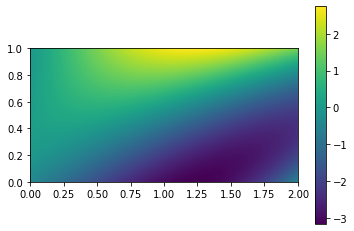

In [102]:
plt.imshow(u_plot, extent = [left, right, bottom, top])
plt.colorbar();

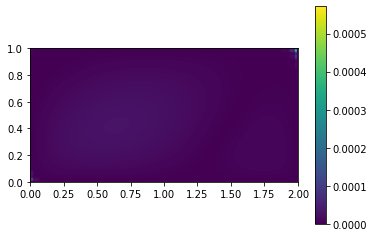

In [104]:
plt.imshow(np.abs(u_plot - u0_plot), extent = [left, right, bottom, top])
plt.colorbar();

In [105]:
error = np.max(np.abs(u_plot - u0_plot))
error

0.0005715560518368967

### Дополнительная задача
В прямоугольник вписан эллипс.
На границе (вне эллипса) sin($\phi$), $\phi$ = atan(x, y)

In [106]:
# Вычисление констант СЛАУ
def SLE_constants_mod(x_plot, y_plot, index, tau,
                      mu, gamma, f, 
                      u_prev, axis=0):
  Nx = len(x_plot)
  Ny = len(y_plot)
  hx = x_plot[1] - x_plot[0]
  hy = y_plot[1] - y_plot[0]

  left   = x_plot[0]
  right  = x_plot[-1]
  bottom = y_plot[0]
  top    = y_plot[-1]

  a = (right - left) / 2
  b = (top - bottom) / 2

  if axis == 0: n = len(x_plot)
  else:         n = len(y_plot)

  a_plot = np.zeros(n, dtype=float)
  b_plot = np.zeros(n, dtype=float)
  c_plot = np.zeros(n, dtype=float)
  f_plot = np.zeros(n, dtype=float)
  
  # Неизвестные вдоль x
  if axis == 0:
    y_j = y_plot[index]
    internal_p = np.where((x_plot - a)**2 / a**2 + (y_j - b)**2 / b**2 < 1, np.NaN, x_plot)
    indexes = np.argwhere(np.isnan(internal_p))

    count = indexes[0][0]
    for i in range(count):
      b_plot[i]         = 1
      b_plot[n - i - 1] = 1
      
      f_plot[i]         = mu(x_plot[i], y_j, left, right, bottom, top)
      f_plot[n - i - 1] = mu(x_plot[n - i - 1], y_j, left, right, bottom, top)
    
    for i in range(count, Nx - count):
      a_plot[i] = tau / (2 * hx**2)
      b_plot[i] = (-1) * (tau / hx**2 + 1)
      c_plot[i] = tau / (2 * hx**2)
      f_plot[i] = (-1) * tau * u_prev[index - 1, i] / (2 * hy**2) + \
                  (tau / hy**2 - 1) * u_prev[index, i] + \
                  (-1) * tau * u_prev[index + 1, i] / (2 * hy**2) - \
                  tau * f(x_plot[i], y_plot[index]) / 2
                    
  else: # Неизвестные вдоль y
    x_i = x_plot[index]
    internal_p = np.where((x_i - a)**2 / a**2 + (y_plot - b)**2 / b**2 < 1, np.NaN, y_plot)
    indexes = np.argwhere(np.isnan(internal_p))

    count = indexes[0][0]
    for i in range(count):
      b_plot[i]         = 1
      b_plot[n - i - 1] = 1
      
      f_plot[i]         = mu(x_i, y_plot[i], left, right, bottom, top)
      f_plot[n - i - 1] = mu(x_i, y_plot[n - i - 1], left, right, bottom, top)
    
    for i in range(count, Ny - count):
      a_plot[i] = tau / (2 * hy**2)
      b_plot[i] = (-1) * (tau / hy**2 + 1)
      c_plot[i] = tau / (2 * hy**2)
      f_plot[i] = (-1) * tau * u_prev[i, index - 1] / (2 * hx**2) + \
                  (tau / hx**2 - 1) * u_prev[i, index] + \
                  (-1) * tau * u_prev[i, index + 1] / (2 * hx**2) - \
                  tau * f(x_plot[index], y_plot[i]) / 2

  return a_plot, b_plot, c_plot, f_plot

In [107]:
def to_stationary_method_mod(x_plot, y_plot, tau,
                             mu, gamma, f, eps):
  left   = x_plot[0]
  right  = x_plot[-1]
  bottom = y_plot[0]
  top    = y_plot[-1]

  # t = 0
  u_prev = np.array([gamma(x_i, y_j) for y_j in y_plot for x_i in x_plot])
  u_prev = u_prev.reshape(len(y_plot), len(x_plot))
  
  # t_k
  while True:
    u_pre = np.zeros((len(y_plot), len(x_plot)))  # t_{k + 1/2}
    u_cur = np.zeros((len(y_plot), len(x_plot)))  # t_{k + 1}

    # Прогонки по x
    u_pre[0] = [mu(x, y_plot[0], left, right, bottom, top) for x in x_plot]
    for ind_y in range(1, len(y_plot) - 1):
      a_plot, b_plot, c_plot, f_plot = SLE_constants_mod(x_plot, y_plot, ind_y, tau, 
                                                     mu, gamma, f,
                                                     u_prev, axis=0)
      u_pre_i = Thomas_algorithm(a_plot, b_plot, c_plot, f_plot)
      u_pre[ind_y] = u_pre_i
    u_pre[-1] = [mu(x, y_plot[-1], left, right, bottom, top) for x in x_plot]

    # Прогонки по y
    u_cur[:, 0] = [mu(x_plot[0], y, left, right, bottom, top) for y in y_plot]
    for ind_x in range(1, len(x_plot) - 1):
      a_plot, b_plot, c_plot, f_plot = SLE_constants_mod(x_plot, y_plot, ind_x, tau, 
                                                     mu, gamma, f,
                                                     u_pre, axis=1)
      u_cur_i = Thomas_algorithm(a_plot, b_plot, c_plot, f_plot)
      u_cur[:, ind_x] = u_cur_i
    u_cur[:, -1] = [mu(x_plot[-1], y, left, right, bottom, top) for y in y_plot]

    if np.max(np.abs(u_cur - u_prev)) < eps:
      return u_cur
    else:
      print(np.max(np.abs(u_cur - u_prev)))
      u_prev = u_cur

In [108]:
# Неоднородность
def f(x, y):
    return 0

# Граничные условия

def mu(x, y, left, right, bottom, top):
  # Полуоси эллипса
  a = (right - left) / 2
  b = (top - bottom) / 2
  if (x - a)**2 / a**2 + (y - b)**2 / b**2 >= 1:
    phi = np.arctan2(y, x)
    return np.sin(phi)
  else:
    raise ValueError("Переданные координаты не соответствуют области на границе/вне эллипса")

# Начальное условие

def gamma(x, y):
  return 0

In [109]:
# Область значений и шаг по x
left  = 0
right = 2
hx    = 0.01

# Область значений и шаг по y
bottom = 0
top    = 1
hy     = 0.01

# Шаг по t
tau = 0.05

# Погрешность
eps = 1.0e-5

In [110]:
# Координатная сетка
x_plot = np.linspace(left, right, round((right - left) / hx) + 1)
y_plot = np.linspace(bottom, top, round((top - bottom) / hy) + 1)

Nx = len(x_plot)
Ny = len(y_plot)

print(len(x_plot), len(y_plot))

201 101


In [111]:
# Численное решение
u_plot = to_stationary_method_mod(x_plot, y_plot, tau,
                                 mu, gamma, f, eps)

1.1774823121961926
0.3069933124853014
0.13438173250287155
0.057804053639195274
0.02869495716163678
0.014360366015228276
0.007101736046430274
0.00562970878210689
0.004521696575964684
0.003633181886172343
0.0029178964588216783
0.002343558476442631
0.00187973245854689
0.0015071243880557805
0.001205758611544816
0.0009636165668933661
0.0007676419471683849
0.0006113064523710632
0.00048800963724737745
0.00039549343563505257
0.00032439580047649574
0.00027318487409944137
0.00023123964209836867
0.00020000485405480273
0.00018131754296335512
0.00016810673575706758
0.0001562358750709647
0.00014519944439250754
0.00013524270527365267
0.0001259709675522913
0.00011757309431881247
0.00010974298789045989
0.00010286511088564154
9.725497395240978e-05
9.210757215238896e-05
8.726433400763067e-05
8.280300164997811e-05
7.86010325216635e-05
7.471602209618844e-05
7.105314814659369e-05
6.765477757753047e-05
6.470430516247738e-05
6.216431854566551e-05
5.973232295342079e-05
5.742353151449997e-05
5.5212212949906636e

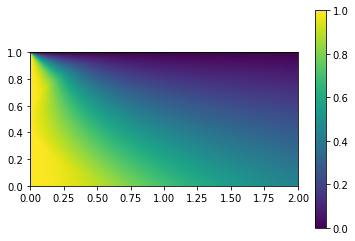

In [112]:
plt.imshow(u_plot, extent=[left, right, bottom, top], interpolation='bilinear')
plt.colorbar()
plt.show()

In [113]:
a = (right - left) / 2
b = (top - bottom) / 2

for i in range(Nx):
    for j in range(Ny):
        if (x_plot[i] - a)**2 / a**2 + (y_plot[j] - b)**2 / b**2 > 1:
            u_plot[j][i] = np.nan

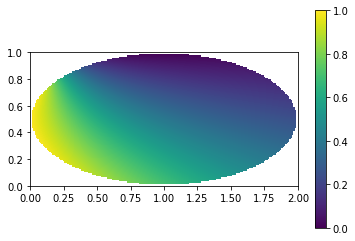

In [114]:
plt.imshow(u_plot, extent=[left, right, bottom, top], interpolation='bilinear')
plt.colorbar()
plt.show()